In [1]:
#モジュールの読み込み
import matplotlib.pyplot as plt
from matplotlib import patches
import math
import random
%matplotlib inline

## 長方形詰込み問題編

In [2]:
# Rectクラス
class Rect():
    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h
        self.w = w
        self.h = h
    
    def overlap(self, b):
        return max(self.x1, b.x1) < min(self.x2, b.x2) and max(self.y1, b.y1) < min(self.y2, b.y2)

    def subtract_by(self, b):
        if self.overlap(b):
            rooms = []
            if (self.x1 < b.x1 and b.x1 < self.x2) and max(self.y1, b.y1) < min(self.y2, b.y2):
                rooms.append(Rect(self.x1, self.y1, b.x1 - self.x1, self.h))

            if (self.x1 < b.x2 and b.x2 < self.x2) and max(self.y1, b.y1) < min(self.y2, b.y2):
                rooms.append(Rect(b.x2, self.y1, self.x2 - b.x2, self.h))

            if (self.y1 < b.y1 and b.y1 < self.y2) and max(self.x1, b.x1) < min(self.x2, b.x2) :
                rooms.append(Rect(self.x1, self.y1, self.w, b.y1 - self.y1))

            if (self.y1 < b.y2 and b.y2 < self.y2) and max(self.x1, b.x1) < min(self.x2, b.x2) :
                rooms.append(Rect(self.x1, b.y2, self.w, self.y2 - b.y2))
            return rooms
        
        else:
            return [self]

    def include(self, b):
        return self.x1 <= b.x1 and b.x2 <= self.x2 and self.y1 <= b.y1 and b.y2 <= self.y2

    def larger_than(self, w, h):
    # 座標は関係なく、図形として入るかどうか
        return w <= self.w and h <= self.h
    
def put_rect(input_rects, roomsORIG):
# 空白矩形と比較し、配置可能な空白を探索
    rects = []
    uniq_rooms = list(roomsORIG)
    for input_rect in input_rects:
        for i in range(len(uniq_rooms)):
            room = uniq_rooms[i]
            if room.larger_than(input_rect[0], input_rect[1]): #このrectに配置可能
                new_rect = Rect(room.x1, room.y1, input_rect[0], input_rect[1])
                rects.append(new_rect)
                break

        # すべての空白矩形から subtractする
        new_rooms = []
        for room in uniq_rooms:
            new_rooms += room.subtract_by(new_rect)
        new_rooms = sorted(new_rooms, key=lambda x:x.y1) # 結局総当たりするので意味ないが、将来効率化を考えソート

        # 重複削除 総当たり
        uniq_rooms = []
        for r_i in new_rooms:
            include_flg = False
            for r_j in new_rooms:
                if r_i == r_j: continue
                if r_j.include(r_i):
                    include_flg = True
                    break
            if not include_flg:
            # print("{} は他のどれにも含まれない".format(r_i))
                uniq_rooms.append(r_i)
        # 低い順（左にある順）に並び替え
        new_rooms = sorted(new_rooms, key=lambda a:a.x1)
        uniq_rooms = sorted(new_rooms, key=lambda a:a.y1)

    return (rects, uniq_rooms)

#Axesオブジェクトに長方形を配置
def Rect_place(rect,n):
    global ax,fig
    ax.grid()
    colors="#"+''.join([random.choice('0123456789ABCDEF') for i in range(3)])
    r = patches.Rectangle( xy=(rect.x1,rect.y1) , width=rect.w, height=rect.h, color=colors)
    ax.add_patch(r)

高さ：8.5


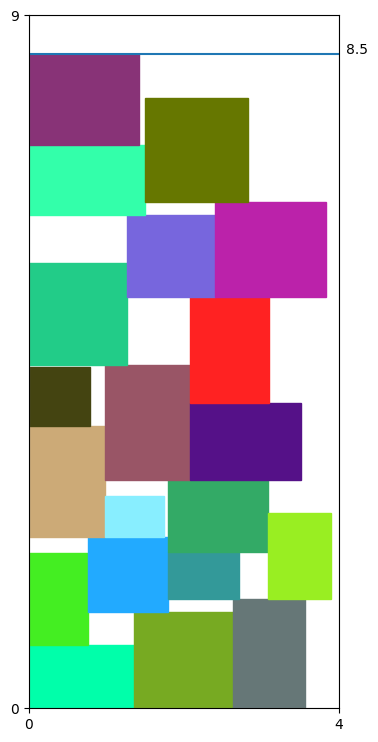

In [33]:
# 実行
seed = 0
random.seed(seed)

# パラメータ設定
W, B, V = 4, 20, 25
# ランダムな長方形を生成
w = [random.uniform(0.5, 1.5) for _ in range(B)]
h = [random.uniform(0.5, 1.5) for _ in range(B)]
scaling_factor = math.sqrt(V / sum(w_i * h_i for w_i, h_i in zip(w, h)))
input_rects = [[w_i * scaling_factor, h_i * scaling_factor] for w_i, h_i in zip(w, h)]

# 配置
rects, rooms = put_rect(input_rects, roomsORIG=[Rect(0,0,W,100)])

# 高さを定義
Height = round(max(rect.y2 for rect in rects), 2)
H = math.ceil(Height)
# Axesオブジェクトを作成
fig, ax = plt.subplots(figsize=(W,H))
ax.set_xticks([0, W])
ax.set_yticks([0, H])
ax.axhline(Height)
plt.text(4.1,Height,Height,size='10')
ax.grid()

for n,rect in enumerate(rects):
    Rect_place(rect,n)
    
# 図形を描画
print(f"高さ：{Height}")
plt.show()

## GA編

In [34]:
import time
from IPython.display import clear_output
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(B), B)
toolbox.register("individual", tools.initIterate, creator.Individual,toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\msy-t\anaconda3\envs\GA\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\msy-t\anaconda3\envs\GA\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [35]:
# 評価関数
def evalRect(individual):
    global input_rects
    copy_rects = input_rects.copy()
    # リスト順にdataを並び替える
    sort_rects = [copy_rects[i] for i in individual]
    
    rects, rooms = put_rect(sort_rects, roomsORIG=[Rect(0,0,W,100)])
    # 最大値
    Height = max(rect.y2 for rect in rects)
    return Height,

### 交叉
#### 部分写像交叉(PMX: Partially-mapped crossover)
　親の一方からは順番の一部をそのまま受け継ぎ，他の親からも残りの順番について、できるだけ多く親の順番を受け継ぐことを目的にしている。そのために，２つのランダムに選んだ切断点間の部分の順番を選び，以下に示す交叉を行う。
例えばつぎに示す２つの親の順番の交叉を考える。

　p1=(1 2 3 | 4 5 6 7 | 8 9)
　p2=(4 5 2 | 1 8 7 6 | 9 3)
 
まず縦棒 | にて示した２点で挟まれた部分を交叉するとつぎに示す子が得られる。ここで * は今のところ未決定であることを示す。

　c1=(* * * | 1 8 7 6 | * *)
　c2=(* * * | 4 5 6 7 | * *)
 
このことは次の入れ替えを定義していることにもなる。
- 1 <-> 4, 8 <-> 5, 7 <-> 6, 6 <-> 7

残りの未決定の部分について、既定のものと衝突を起こさないもの（即ち，既定のものに含まれないもの）はそのまま入れると、つぎの順番が得られる。

　c1=(* 2 3 | 1 8 7 6 | * 9)
　c2=(* * 2 | 4 5 6 7 | 9 3)

最後に残った部分には前記の入れ替えの定義を参照して衝突を起こさないように入れる。即ち、*c1*については１番目の * には1の代わりに4を入れ、８番目の * には8 の代わりに 5 を入れる。同様の操作を*c2*についても 行うと次の経路が得られる。

　o1=(4 2 3 | 1 8 7 6 | 5 9)
　o2=(1 8 2 | 4 5 6 7 | 9 3)
 
この方法は類似性と順序を保存している点に特徴がある。

### 突然変異
- 転座　ランダムに選んだ２つの順序を入れ替える。
- 挿入　ランダムに選んだ１つの番号を取り出してその位置を詰め、同じくランダムに   選んだ１つの番号の所に挿入し、それ以降をずらす。

今回選んだのは**転座**

In [36]:
# 評価関数、交差、突然変異、選択淘汰
toolbox.register("evaluate", evalRect)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selRoulette)

### 数値
交叉確率は50％\
突然変異確率は20％\
初期個体群は30\
世代数は50

In [37]:
def main():
    pop = toolbox.population(n=300)
    CXPB, MUTPB ,NGEN = 0.5, 0.2, 50
    clear_output(True)
    print("Start of evolution")

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    fits = [ind.fitness.values[0] for ind in pop]
    log_min = [min(fits)]
    log_max = [max(fits)]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    log_mean = [mean]
    log_std = [std]
    
    print("  Evaluated %i individuals" % len(pop))
    
    for g in range(NGEN):
        
        
        print("-- Generation %i --" % g)

        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))

        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        
        # 母集団の最小、最大、平均、標準偏差を表示
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        log_min.append(min(fits))
        log_max.append(max(fits))
        log_mean.append(mean)
        log_std.append(std)
        gen = list(range(0, NGEN+1))

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        
    print("-- End of (successful) evolution --")
    #clear_output()
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    return best_ind, gen, log_min, log_max, log_mean, log_std

In [38]:
t1 = time.time()
if __name__ == "__main__":
    best_ind, gen, log_min, log_max, log_mean, log_std = main()
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time: .2f}秒")

Start of evolution
  Evaluated 300 individuals
-- Generation 0 --
  Evaluated 152 individuals
  Min 6.926748175550161
  Max 9.317720446567927
  Avg 8.081581279291191
  Std 0.3700441062261561
-- Generation 1 --
  Evaluated 183 individuals
  Min 7.1932067139188485
  Max 9.928583521655106
  Avg 8.108897578943543
  Std 0.3934664732027748
-- Generation 2 --
  Evaluated 180 individuals
  Min 7.140768674647099
  Max 9.601538039101719
  Avg 8.072782920193136
  Std 0.3949380483482608
-- Generation 3 --
  Evaluated 179 individuals
  Min 7.25976787754024
  Max 9.373874571828654
  Avg 8.076729964131259
  Std 0.3521989043291864
-- Generation 4 --
  Evaluated 194 individuals
  Min 7.197405864091731
  Max 9.122547253033341
  Avg 8.076874394179784
  Std 0.36326115265699077
-- Generation 5 --
  Evaluated 196 individuals
  Min 7.191287850727748
  Max 9.113907151423923
  Avg 8.057715478124589
  Std 0.3840409433358561
-- Generation 6 --
  Evaluated 196 individuals
  Min 7.147196515180278
  Max 9.113907151

高さ：7.11


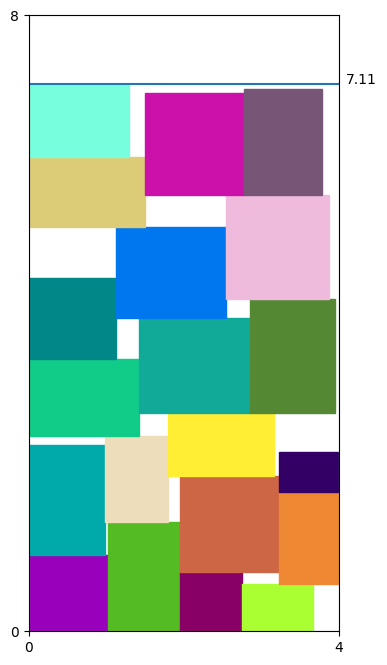

In [39]:
#描画
copy_rects = input_rects.copy()
sort_rects = [copy_rects[i] for i in best_ind]
rects, rooms = put_rect(sort_rects, roomsORIG=[Rect(0,0,W,100)])

Height = round(max(rect.y2 for rect in rects), 2)
H = math.ceil(Height)
fig, ax = plt.subplots(figsize=(W,H))
ax.set_xticks([0, W])
ax.set_yticks([0, H])
ax.axhline(Height)
plt.text(4.1,Height,Height,size='10')
ax.grid()

for n,rect in enumerate(rects):
    Rect_place(rect,n)

#図形を描画
print(f"高さ：{Height}")
plt.show()

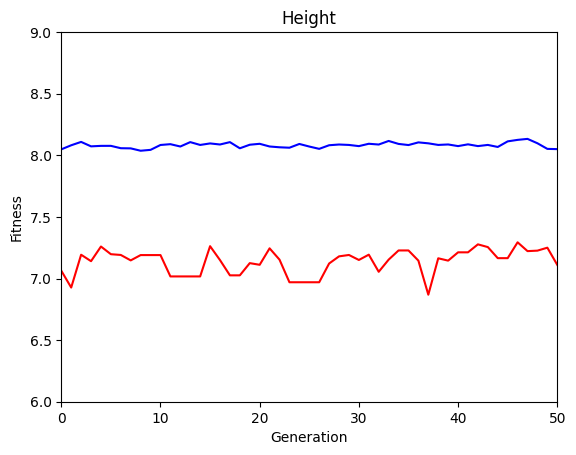

In [40]:
#描画2
x = gen
y1 = log_min
y2 = log_max
y3 = log_mean
y4 = log_std

fig, ax = plt.subplots()
plt.xlim(0,len(x)-1)
plt.ylim(6,H+1)
ax.plot(x, y1,"r", y3,"b")

plt.title("Height")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

plt.show()